In [25]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


pd.set_option("display.max_columns", 500)

In [2]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep parquet

216M -rw-r--r-- 1 nobody 216M Mar 23 07:10 Combined_Flights_2018.parquet
295M -rw-r--r-- 1 nobody 295M Mar 23 07:11 Combined_Flights_2019.parquet
175M -rw-r--r-- 1 nobody 175M Mar 23 07:11 Combined_Flights_2020.parquet
232M -rw-r--r-- 1 nobody 232M Mar 23 07:11 Combined_Flights_2021.parquet
143M -rw-r--r-- 1 nobody 143M Mar 23 07:11 Combined_Flights_2022.parquet


In [3]:
!ls -GFlash ../input/flight-delay-dataset-20182022/ | grep csv

 40K -rw-r--r-- 1 nobody  39K Mar 23 07:10 Airlines.csv
1.9G -rw-r--r-- 1 nobody 1.9G Mar 23 07:14 Combined_Flights_2018.csv
2.7G -rw-r--r-- 1 nobody 2.7G Mar 23 07:14 Combined_Flights_2019.csv
1.7G -rw-r--r-- 1 nobody 1.7G Mar 23 07:13 Combined_Flights_2020.csv
2.1G -rw-r--r-- 1 nobody 2.1G Mar 23 07:14 Combined_Flights_2021.csv
1.4G -rw-r--r-- 1 nobody 1.4G Mar 23 07:13 Combined_Flights_2022.csv


# Read in and Format Data

In [4]:
def get_time_category(deptime):
    # Преобразуем время в строку и добавляем ведущий ноль, если необходимо
    time_str = f"{int(deptime):04}"
    hours = int(time_str[:2])
    minutes = int(time_str[2:])
    
    if 6 <= hours < 12:
        return "Morning"
    elif 12 <= hours < 18:
        return "Day"
    elif 18 <= hours < 24:
        return "Evening"
    else:
        return "Night"

def target_encode(train_df, valid_df, test_df, column, target):
    # Вычисляем среднее значение целевой переменной для каждой категории в обучающей выборке
    mean_target = train_df.groupby(column)[target].mean()
    
    # Применяем кодирование к обучающей и тестовой выборкам
    train_df[column] = train_df[column].map(mean_target)
    test_df[column] = test_df[column].map(mean_target)
    valid_df[column] = valid_df[column].map(mean_target)
    
    # Заполняем пропуски (если есть категории, которые не встречались в обучающей выборке)
    train_df[column].fillna(train_df[target].mean(), inplace=True)
    test_df[column].fillna(train_df[target].mean(), inplace=True)
    valid_df[column].fillna(train_df[target].mean(), inplace=True)
    
    return train_df, valid_df, test_df, 

In [5]:
parquet_files = glob("../input/flight-delay-dataset-20182022/*.parquet")

In [6]:
column_subset = ["Flight_Number_Marketing_Airline", 'Month', 'DayOfWeek', 'DayofMonth', 'DOT_ID_Operating_Airline','Distance',
          'DistanceGroup', 'DestAirportSeqID','CRSDepTime', 'IATA_Code_Operating_Airline',
          'Airline', 'OriginAirportID', 'DestCityName', 'DestAirportID', 'Diverted', 'Cancelled',
          'IATA_Code_Marketing_Airline', 'DepDelayMinutes']

dfs = []
for f in parquet_files:
    dfs.append(pd.read_parquet(f, columns=column_subset))
df = pd.concat(dfs).reset_index(drop=True)

In [7]:
df = df[df['CRSDepTime'].isna() == False]

df['daytime'] = df['CRSDepTime'].apply(get_time_category)

cat_cols = ['DOT_ID_Operating_Airline', 'Airline', 'OriginAirportID','DistanceGroup', 'IATA_Code_Operating_Airline',
                'DestCityName', 'DestAirportID','IATA_Code_Marketing_Airline', 'daytime']

for c in df.columns:
    print(df[c].isna().value_counts(), end='\n\n')

False    29193782
Name: Flight_Number_Marketing_Airline, dtype: int64

False    29193782
Name: Month, dtype: int64

False    29193782
Name: DayOfWeek, dtype: int64

False    29193782
Name: DayofMonth, dtype: int64

False    29193782
Name: DOT_ID_Operating_Airline, dtype: int64

False    29193782
Name: Distance, dtype: int64

False    29193782
Name: DistanceGroup, dtype: int64

False    29193782
Name: DestAirportSeqID, dtype: int64

False    29193782
Name: CRSDepTime, dtype: int64

False    29193782
Name: IATA_Code_Operating_Airline, dtype: int64

False    29193782
Name: Airline, dtype: int64

False    29193782
Name: OriginAirportID, dtype: int64

False    29193782
Name: DestCityName, dtype: int64

False    29193782
Name: DestAirportID, dtype: int64

False    29193782
Name: Diverted, dtype: int64

False    29193782
Name: Cancelled, dtype: int64

False    29193782
Name: IATA_Code_Marketing_Airline, dtype: int64

False    28430698
True       763084
Name: DepDelayMinutes, dtype: int64

Fal

**Dropping samples with Nan values.**

In [8]:
df.dropna(how='any', inplace=True)

In [9]:
df.shape

(28430698, 19)

**Matching each sample to the delay group.**

In [10]:
df["DelayGroup"] = None

df.loc[df["DepDelayMinutes"] == 0, "DelayGroup"] = "OnTime_Early"

df.loc[
    (df["DepDelayMinutes"] > 0) & (df["DepDelayMinutes"] <= 120), "DelayGroup"
] = "Small_Delay"

df.loc[
    (df["DepDelayMinutes"] > 120) & (df["DepDelayMinutes"] <= 240), "DelayGroup"
] = "Medium_Delay"

df.loc[
(df["DepDelayMinutes"] > 240) & (df["DepDelayMinutes"] <= 480), "DelayGroup"] = "Large_Delay"

df.loc[df["DepDelayMinutes"] > 480, "DelayGroup"] = "Very_Large_Delay"

df.loc[df["Cancelled"], "DelayGroup"] = "Cancelled"

**Lets encode target variable**

In [11]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['DelayGroup'] = encoder.fit_transform(df['DelayGroup'])

In [12]:
print("Categories:", encoder.classes_)
print("Matching:", dict(zip(encoder.classes_, range(len(encoder.classes_)))))

Categories: ['Cancelled' 'Large_Delay' 'Medium_Delay' 'OnTime_Early' 'Small_Delay'
 'Very_Large_Delay']
Matching: {'Cancelled': 0, 'Large_Delay': 1, 'Medium_Delay': 2, 'OnTime_Early': 3, 'Small_Delay': 4, 'Very_Large_Delay': 5}


In [13]:
df['DelayGroup'].value_counts()

3    19240509
4     8518144
2      495912
1      122096
5       38741
0       15296
Name: DelayGroup, dtype: int64

In [14]:
df.to_parquet('data.parquet', engine='pyarrow')

In [15]:
X = df[['Month', 'DayOfWeek', 'DayofMonth', 'DOT_ID_Operating_Airline', 'Distance',
          'DistanceGroup', 'DestAirportSeqID', 'daytime', 'DepDelayMinutes',
          'Airline', 'OriginAirportID', 'DestCityName', 'DestAirportID', 'Diverted', 'Cancelled',
          'IATA_Code_Operating_Airline', 'IATA_Code_Marketing_Airline']]
y = df['DelayGroup']

**Split data on train, validation and test sets.**

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

**Using target encoder to encode categorical features.**

In [17]:
X_train_enc, X_valid_enc, X_test_enc = X_train, X_valid, X_test

for col in cat_cols:
    X_train_enc, X_valid_enc, X_test_enc = target_encode(X_train, X_valid, X_test, col, 'DepDelayMinutes')

X_train_enc.drop('DepDelayMinutes', axis=1, inplace=True)
X_valid_enc.drop('DepDelayMinutes', axis=1, inplace=True)
X_test_enc.drop('DepDelayMinutes', axis=1, inplace=True)

In [18]:
from xgboost import XGBClassifier

In [19]:
models = {
    'XGBoost': XGBClassifier(n_estimators=1000, random_state=42)}

In [20]:
for model_name, model in models.items():
    print(f"Training {model_name}...")

    eval_set = [(X_train_enc, y_train), (X_valid_enc, y_valid)]
    
    # Train the model
    model.fit(X_train_enc, y_train, eval_set=eval_set, verbose=True)
    
    # Predict on the validation set
    y_val_pred = model.predict(X_valid_enc)
    
    # Evaluate the model on the validation set
    val_accuracy = accuracy_score(y_valid, y_val_pred)
    print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")
    print(classification_report(y_valid, y_val_pred))
    
    # Predict on the test set
    y_test_pred = model.predict(X_test_enc)
    
    # Evaluate the model on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
    print(classification_report(y_test, y_test_pred))
    print("-" * 60)

Training XGBoost...
[13:26:08] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estinators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.39568	validation_1-mlogloss:1.39573
[1]	validation_0-mlogloss:1.19197	validation_1-mlogloss:1.19203
[2]	validation_0-mlogloss:1.06088	validation_1-mlogloss:1.06096
[3]	validation_0-mlogloss:0.97034	validation_1-mlogloss:0.97044
[4]	validation_0-mlogloss:0.90538	validation_1-mlogloss:0.90547
[5]	validation_0-mlogloss:0.85732	validation_1-mlogloss:0.85741
[6]	validation_0-mlogloss:0.82099	validation_1-mlogloss:0.82108
[7]	validation_0-mlogloss:0.79314	validation_1-mlogloss:0.79323
[8]	validation_0-mlogloss:0.77167	validation_1-mlogloss:0.77175
[9]	validation_0-mlogloss:0.75464	validat

NameError: name 'accuracy_score' is not defined

In [23]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Evaluate the model on the validation set
val_accuracy = accuracy_score(y_valid, y_val_pred)
print(f"{model_name} Validation Accuracy: {val_accuracy:.4f}")
print(classification_report(y_valid, y_val_pred))

# Predict on the test set
y_test_pred = model.predict(X_test_enc)

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"{model_name} Test Accuracy: {test_accuracy:.4f}")
print(classification_report(y_test, y_test_pred))
print("-" * 60)

XGBoost Validation Accuracy: 0.7002
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2487
           1       0.20      0.00      0.00     19323
           2       0.38      0.00      0.00     79602
           3       0.71      0.94      0.81   3078464
           4       0.59      0.21      0.31   1362899
           5       0.00      0.00      0.00      6137

    accuracy                           0.70   4548912
   macro avg       0.48      0.36      0.35   4548912
weighted avg       0.67      0.70      0.64   4548912

XGBoost Test Accuracy: 0.7002
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3038
           1       0.12      0.00      0.00     24453
           2       0.50      0.00      0.00     98970
           3       0.71      0.94      0.81   3847321
           4       0.59      0.21      0.31   1704704
           5       0.75      0.00      0.00      7654

    accurac

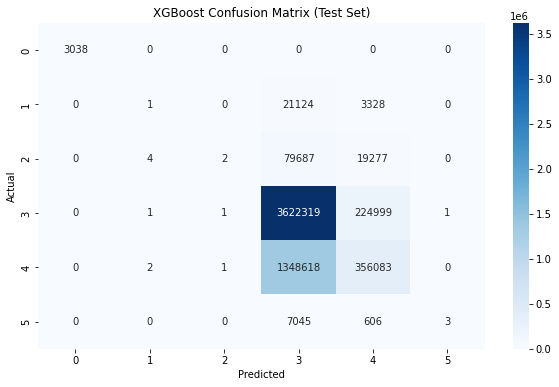

In [28]:
import seaborn as sns

# Plot the confusion matrix for the test set
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_confusion_matrix(y_test, y_test_pred, title='XGBoost Confusion Matrix (Test Set)')

In [33]:
import pickle

with open('xgb_model_1.pkl', 'wb') as f:
    pickle.dump(model, f)